# Healthcare Analytics Demonstration
## Analysis of CMS Enrollment and Claims Data

Description:
We will analyze CMS SynPUF enrollment and claims data using Python pandas. From the enrollment data, we can calculate high-level expense rates and analyze by demographic or condition categories.

Data Source: [CMS 2008-2010 Data Entrepreneurs Synthetic Public Use File](https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/DESample01), a.k.a., CMS SynPUF

## Part 1: Enrollment Data and Per Person per Month/Year (PMPM/PMPY) Analysis

### Setup

In [1]:
import pandas as pd
import logging
import seaborn as sns

# pandas/logging/seaborn configuration for jupyter
pd.set_option('max_columns', None), pd.set_option('max_rows', 1000), pd.set_option('max_colwidth', None)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S')
sns.set()

# this disables unnecessary matplotlib/seaborng logging
logging.getLogger('matplotlib.font_manager').disabled = True

# helper class to allow displaying multiple dataframes side-by-side in jupyter
class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)

### Import data

In [2]:
# read 2008 Beneficiary Summary File from CMS URL
    # we can retrieve additional years and samples (01-20) if we want within memory constraints
    # by parameterizing the URL
url = r'https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/Downloads/DE1_0_2008_Beneficiary_Summary_File_Sample_1.zip'
benes_df = pd.read_csv(url, dtype={'BENE_DEATH_DT': 'Int32', 'BENE_ESRD_IND': 'category'})
logging.info(f'Read file from: {url}')

12-Jan-22 01:03:47 - Read file from: https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/Downloads/DE1_0_2008_Beneficiary_Summary_File_Sample_1.zip


### Preview Data

In [3]:
import io

# pipe df.info() to logging
buffer = io.StringIO()
benes_df.info(buf=buffer)
s = buffer.getvalue()
s = 'Summary of `benes_df` dataframe:\n\n\t' + s.replace('\n', '\n\t')
logging.info(s)

12-Jan-22 01:03:47 - Summary of `benes_df` dataframe:

	<class 'pandas.core.frame.DataFrame'>
	RangeIndex: 116352 entries, 0 to 116351
	Data columns (total 32 columns):
	 #   Column                    Non-Null Count   Dtype   
	---  ------                    --------------   -----   
	 0   DESYNPUF_ID               116352 non-null  object  
	 1   BENE_BIRTH_DT             116352 non-null  int64   
	 2   BENE_DEATH_DT             1814 non-null    Int32   
	 3   BENE_SEX_IDENT_CD         116352 non-null  int64   
	 4   BENE_RACE_CD              116352 non-null  int64   
	 5   BENE_ESRD_IND             116352 non-null  category
	 6   SP_STATE_CODE             116352 non-null  int64   
	 7   BENE_COUNTY_CD            116352 non-null  int64   
	 8   BENE_HI_CVRAGE_TOT_MONS   116352 non-null  int64   
	 9   BENE_SMI_CVRAGE_TOT_MONS  116352 non-null  int64   
	 10  BENE_HMO_CVRAGE_TOT_MONS  116352 non-null  int64   
	 11  PLAN_CVRG_MOS_NUM         116352 non-null  int64   
	 12  SP_ALZHDMTA  

In [4]:
benes_df.head()

,DESYNPUF_ID,BENE_BIRTH_DT,BENE_DEATH_DT,BENE_SEX_IDENT_CD,BENE_RACE_CD,BENE_ESRD_IND,SP_STATE_CODE,BENE_COUNTY_CD,BENE_HI_CVRAGE_TOT_MONS,BENE_SMI_CVRAGE_TOT_MONS,BENE_HMO_CVRAGE_TOT_MONS,PLAN_CVRG_MOS_NUM,SP_ALZHDMTA,SP_CHF,SP_CHRNKIDN,SP_CNCR,SP_COPD,SP_DEPRESSN,SP_DIABETES,SP_ISCHMCHT,SP_OSTEOPRS,SP_RA_OA,SP_STRKETIA,MEDREIMB_IP,BENRES_IP,PPPYMT_IP,MEDREIMB_OP,BENRES_OP,PPPYMT_OP,MEDREIMB_CAR,BENRES_CAR,PPPYMT_CAR
0,00013D2EFD8E45D1,19230501,<NA>,1,1,0,26,950,12,12,12,12,2,2,2,2,2,2,2,2,2,2,2,0.0,0.0,0.0,50.0,10.0,0.0,0.0,0.0,0.0
1,00016F745862898F,19430101,<NA>,1,1,0,39,230,12,12,0,0,2,2,2,2,2,2,2,2,2,2,2,0.0,0.0,0.0,0.0,0.0,0.0,700.0,240.0,0.0
2,0001FDD721E223DC,19360901,<NA>,2,1,0,39,280,12,12,0,12,2,2,2,2,2,2,2,2,2,2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00021CA6FF03E670,19410601,<NA>,1,5,0,6,290,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00024B3D2352D2D0,19360801,<NA>,1,1,0,52,590,12,12,0,0,2,2,2,2,2,2,2,2,1,2,2,0.0,0.0,0.0,30.0,40.0,0.0,220.0,80.0,0.0


### Preprocess

In [5]:
# downsize integer types
benes_df[benes_df.select_dtypes('int64').columns] = benes_df.select_dtypes('int64').astype('Int32')

# restrict columns
columns_to_keep = [    
    # demographic
    'DESYNPUF_ID', 'BENE_BIRTH_DT', 'BENE_DEATH_DT', 'BENE_SEX_IDENT_CD', 'BENE_RACE_CD', 'BENE_ESRD_IND', 'SP_STATE_CODE', 

    # condition flags
    'SP_CNCR', 'SP_COPD', 'SP_DEPRESSN', 'SP_DIABETES', 'SP_ISCHMCHT', 'SP_OSTEOPRS', 'SP_RA_OA', 'SP_STRKETIA',     
    
    # payment variables, member months
    'MEDREIMB_IP', 'MEDREIMB_OP', 'MEDREIMB_CAR', 'PLAN_CVRG_MOS_NUM',
]

benes_df = benes_df[columns_to_keep]

# convert column names to lower case
benes_df.columns = [col.lower() for col in benes_df.columns]

In [6]:
# remap condition flags
    # from: 1 (Yes) and 2 (No)
    # to: 1 (Yes) and 0 (No)

condition_cols = ['sp_cncr', 'sp_copd', 'sp_depressn', 'sp_diabetes', 'sp_ischmcht', 'sp_osteoprs', 'sp_ra_oa', 'sp_strketia']
benes_df[condition_cols] = benes_df[condition_cols].apply(lambda x: x.map({1: 1, 2: 0}))

### Data Exploration, Data Quality Checks

#### Check unique member vs row counts

In [7]:
if benes_df['desynpuf_id'].nunique() == benes_df.shape[0]:
    logging.info('TEST PASSED - Beneficiary file unique member count matches row count.')
else:
    logging.info('TEST FAILED - Beneficiary file unique member count does not match row count.')

12-Jan-22 01:03:48 - TEST PASSED - Beneficiary file unique member count matches row count.


#### Inspect value counts (up to top 5 values) for each categorical column

* This is a little hacky in how we call pd.Series.value_counts() on several columns and display at once. This is just to keep the notebook pretty (avoid lengthy/tall output).
* e.g., we can see 92.9% of members do not have end-stage renal disease (bene_esrd_in==0)

In [8]:
cols_to_check = ['bene_sex_ident_cd', 'bene_race_cd', 'bene_esrd_ind', 
                 'sp_state_code', 'sp_cncr', 'sp_copd', 'sp_depressn', 
                 'sp_diabetes', 'sp_ischmcht', 'sp_osteoprs', 'sp_ra_oa', 'sp_strketia',]

for col in cols_to_check:
    globals()[col] = pd.DataFrame(benes_df[col].value_counts(normalize=True).iloc[:5])
    
display(*cols_to_check)

,bene_sex_ident_cd
2,0.553037
1,0.446963
,bene_race_cd
1,0.828082
2,0.106083
3,0.04238
5,0.023455
,bene_esrd_ind
0,0.929
Y,0.071


#### Summarize condition prevalence

In [9]:
# get condition prevalence as sum of 1s (Yes indicator) divided by row count (members)
condition_prevalence = (benes_df[condition_cols].sum() / benes_df[condition_cols].shape[0])

# format to %
condition_prevalence = pd.DataFrame(condition_prevalence.apply(lambda s: '{:.2f}%'.format(s*100)), columns=['prevalence'])
condition_prevalence

,prevalence
sp_cncr,6.37%
sp_copd,13.53%
sp_depressn,21.35%
sp_diabetes,37.87%
sp_ischmcht,42.06%
sp_osteoprs,17.34%
sp_ra_oa,15.40%
sp_strketia,4.49%


# Analytical Calculations

* analyze age distribution based on birth date
* calculate Per Person Per Month (PMPM) for Inpatient, Outpatient, and Professional claims
* show PMPM by demographic categories: age, sex, race, ESRD status, chronic condition

#### Age Distribution
* We calculate age using `relativedelta` module, which should be more accurate. 
* `age_basic` gets to a similar result but may run into edge cases.
* We have to define an `age_as_of_date` to bound the age to a reference date
* For simplicity, we are ignoring the death date

In [10]:
from datetime import datetime 
from dateutil.relativedelta import relativedelta
import numpy as np

# set reference date
age_as_date = datetime(year=2008, month=12, day=31)

# convert from source integer smarter datetime object
benes_df['bene_birth_dt'] = pd.to_datetime(benes_df['bene_birth_dt'], format='%Y%m%d')

# calculate age using relative delta
benes_df['age'] = benes_df['bene_birth_dt'].apply(lambda dob: relativedelta(age_as_date, dob).years)

# basic/naive method using 365.25; might have incorrect edge cases
benes_df['age_basic'] = (age_as_date - benes_df['bene_birth_dt']).dt.days / 365.25
benes_df['age_basic'] = np.floor(benes_df['age_basic']).astype('Int32')

# cut age value into categorical bins
bins = range(25, 115, 10)
benes_df['age_bin'] = pd.cut(benes_df['age'], bins, include_lowest=True)

In [11]:
# preview age columns
benes_df[['bene_birth_dt', 'age', 'age_basic', 'age_bin']].head()

,bene_birth_dt,age,age_basic,age_bin
0,1923-05-01,85,85,"(75.0, 85.0]"
1,1943-01-01,65,65,"(55.0, 65.0]"
2,1936-09-01,72,72,"(65.0, 75.0]"
3,1941-06-01,67,67,"(65.0, 75.0]"
4,1936-08-01,72,72,"(65.0, 75.0]"


In [12]:
# age distribution
benes_df['age_bin'].value_counts(dropna=False).sort_values()

(24.999, 35.0]     1876
(95.0, 105.0]      2266
(35.0, 45.0]       3219
(45.0, 55.0]       6199
(85.0, 95.0]      10727
(55.0, 65.0]      13323
(75.0, 85.0]      31016
(65.0, 75.0]      47726
Name: age_bin, dtype: int64

**Different ways to plot a histogram with `seaborn`**

<AxesSubplot:xlabel='age', ylabel='Count'>

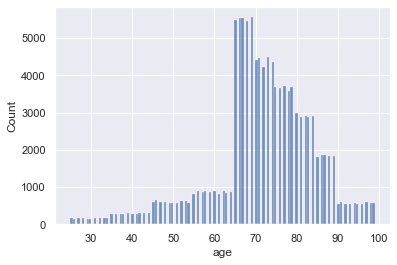

In [13]:
sns.histplot(data=benes_df, x='age')

<AxesSubplot:xlabel='age', ylabel='Count'>

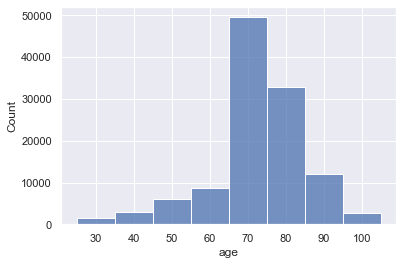

In [14]:
sns.histplot(data=benes_df, x='age', bins=bins)

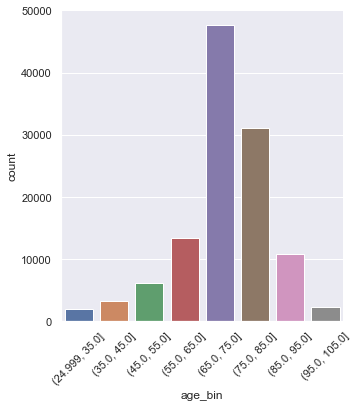

In [15]:
sns.catplot(data=benes_df.sort_values(by=['age_bin']), 
            x='age_bin', 
            kind='count') \
            .set_xticklabels(rotation=45)

### Calculate PMPM and PMPY (Per Person Per Month/Year) expenses
* calculation: total expense divided by total member months (or year)
* the payments by Medicare are represented in columns: 'medreimb_ip', 'medreimb_op', 'medreimb_car'
* 'car' is short for "carrier" claims; a legacy term that refers to non-facility professional

### PMPM by Claim Type and Total PMPM

In [16]:
# paid amounts by claim type
payment_columns = ['medreimb_ip', 'medreimb_op', 'medreimb_car']
benes_df['medreimb_total'] = benes_df[payment_columns].sum(axis=1)
benes_df[payment_columns].sum() / benes_df['plan_cvrg_mos_num'].sum()

medreimb_ip     324.352408
medreimb_op      91.149139
medreimb_car    170.233887
dtype: float64

In [17]:
# paid amount total
benes_df['medreimb_total'].sum() / benes_df['plan_cvrg_mos_num'].sum()

585.7354335348174

### Total PMPY

QA check: ~$7,000 paid amount per beneficiary seems reasonable

In [18]:
# paid amount total
benes_df['medreimb_total'].sum() / benes_df['plan_cvrg_mos_num'].sum() * 12

7028.825202417809

### PMPM by demographic category

First we calculate PMPM by Sex/Gender. We will generalize this into a function into which we can "pipe" a dataframe.

In [19]:
grouped = benes_df.groupby(['bene_sex_ident_cd'], as_index=False).agg({'medreimb_total': 'sum', 'plan_cvrg_mos_num': 'sum'})
grouped['pmpm'] = grouped['medreimb_total'] / grouped['plan_cvrg_mos_num']
grouped

,bene_sex_ident_cd,medreimb_total,plan_cvrg_mos_num,pmpm
0,1,202596470.0,323386,626.484975
1,2,262637370.0,470887,557.75031


In [20]:
def pmpm_by_category(benes_df, category=None) -> pd.DataFrame:
    """Takes any categorical column from beneficiary file and returns PMPM dataframe grouped on that column."""    
    grouped = benes_df.groupby([category]).agg({'medreimb_total': 'sum', 'plan_cvrg_mos_num': 'sum'})
    grouped['pmpm'] = grouped['medreimb_total'] / grouped['plan_cvrg_mos_num']
    return grouped[['pmpm']]

In [21]:
benes_df.pipe(pmpm_by_category, category='bene_sex_ident_cd')

,pmpm
bene_sex_ident_cd,
1,626.484975
2,557.75031


Here we can tabulate the PMPM by various demographic categories. For example, we can see the extent to which PMPM increases/decrease when a beneficiary has a particluar chronic condition.

In [22]:
pmpm_by_sex = benes_df.pipe(pmpm_by_category, category='bene_sex_ident_cd')
pmpm_by_race = benes_df.pipe(pmpm_by_category, category='bene_race_cd')
pmpm_by_diabetes_status = benes_df.pipe(pmpm_by_category, category='sp_diabetes')
pmpm_by_esrd_status = benes_df.pipe(pmpm_by_category, category='bene_esrd_ind')

# display dataframes using special helper class defined earlier
display('pmpm_by_sex', 'pmpm_by_race', 'pmpm_by_diabetes_status', 'pmpm_by_esrd_status')

,pmpm
bene_sex_ident_cd,
1,626.484975
2,557.75031
,pmpm
bene_race_cd,
1,605.190157
2,565.455487
3,406.413847
5,396.407894
,pmpm


# Part 2: Inpatient Claims Data and Calculating Expenses per Inpatient Admission

The grain of this data set is member-claimID level. Diagnoses (Dx'es) in the source are pivoted into separate columns, which we will fix.

Simplifying assumption: we will equate 1 facility inpatient claim ID with an admission. 
* In reality, multiple claims may be associated with an admission. 
* We would require additional medical grouper logic to check admission and discharge dates to capture related claims while separating episodes. 
* For example, a Rehab DRG may proceed a Surgery DRG. Those would generally be considered separate admission events for purposes of economic analysis.

### Load the data

In [23]:
ip_claims_df = pd.read_csv('https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/Downloads/DE1_0_2008_to_2010_Inpatient_Claims_Sample_1.zip')

# convert column labels to lower case
ip_claims_df.columns = [col.lower() for col in ip_claims_df.columns]

### Inspect

In [24]:
ip_claims_df.head()

,desynpuf_id,clm_id,segment,clm_from_dt,clm_thru_dt,prvdr_num,clm_pmt_amt,nch_prmry_pyr_clm_pd_amt,at_physn_npi,op_physn_npi,ot_physn_npi,clm_admsn_dt,admtng_icd9_dgns_cd,clm_pass_thru_per_diem_amt,nch_bene_ip_ddctbl_amt,nch_bene_pta_coinsrnc_lblty_am,nch_bene_blood_ddctbl_lblty_am,clm_utlztn_day_cnt,nch_bene_dschrg_dt,clm_drg_cd,icd9_dgns_cd_1,icd9_dgns_cd_2,icd9_dgns_cd_3,icd9_dgns_cd_4,icd9_dgns_cd_5,icd9_dgns_cd_6,icd9_dgns_cd_7,icd9_dgns_cd_8,icd9_dgns_cd_9,icd9_dgns_cd_10,icd9_prcdr_cd_1,icd9_prcdr_cd_2,icd9_prcdr_cd_3,icd9_prcdr_cd_4,icd9_prcdr_cd_5,icd9_prcdr_cd_6,hcpcs_cd_1,hcpcs_cd_2,hcpcs_cd_3,hcpcs_cd_4,hcpcs_cd_5,hcpcs_cd_6,hcpcs_cd_7,hcpcs_cd_8,hcpcs_cd_9,hcpcs_cd_10,hcpcs_cd_11,hcpcs_cd_12,hcpcs_cd_13,hcpcs_cd_14,hcpcs_cd_15,hcpcs_cd_16,hcpcs_cd_17,hcpcs_cd_18,hcpcs_cd_19,hcpcs_cd_20,hcpcs_cd_21,hcpcs_cd_22,hcpcs_cd_23,hcpcs_cd_24,hcpcs_cd_25,hcpcs_cd_26,hcpcs_cd_27,hcpcs_cd_28,hcpcs_cd_29,hcpcs_cd_30,hcpcs_cd_31,hcpcs_cd_32,hcpcs_cd_33,hcpcs_cd_34,hcpcs_cd_35,hcpcs_cd_36,hcpcs_cd_37,hcpcs_cd_38,hcpcs_cd_39,hcpcs_cd_40,hcpcs_cd_41,hcpcs_cd_42,hcpcs_cd_43,hcpcs_cd_44,hcpcs_cd_45
0,00013D2EFD8E45D1,196661176988405,1,20100312.0,20100313.0,2600GD,4000.0,0.0,3.139084e+09,NaN,NaN,20100312,4580,0.0,1100.0,0.0,0.0,1.0,20100313,217,7802,78820,V4501,4280,2720,4019,V4502,73300,E9330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00016F745862898F,196201177000368,1,20090412.0,20090418.0,3900MB,26000.0,0.0,6.476809e+09,NaN,NaN,20090412,7866,0.0,1068.0,0.0,0.0,6.0,20090418,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00016F745862898F,196661177015632,1,20090831.0,20090902.0,3900HM,5000.0,0.0,6.119985e+08,6.119985e+08,NaN,20090831,6186,0.0,1068.0,0.0,0.0,2.0,20090902,750,6186,2948,56400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7092.0,6186,V5866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00016F745862898F,196091176981058,1,20090917.0,20090920.0,3913XU,5000.0,0.0,4.971603e+09,NaN,1.119000e+09,20090917,29590,0.0,1068.0,0.0,0.0,3.0,20090920,883,29623,30390,71690,34590,V1581,32723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00016F745862898F,196261176983265,1,20100626.0,20100701.0,3900MB,16000.0,0.0,6.408400e+09,1.960860e+09,NaN,20100626,5849,0.0,1100.0,0.0,0.0,5.0,20100701,983,3569,4019,3542,V8801,78820,2639,7840,7856,4271,NaN,NaN,E8889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
ip_claims_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66773 entries, 0 to 66772
Data columns (total 81 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   desynpuf_id                     66773 non-null  object 
 1   clm_id                          66773 non-null  int64  
 2   segment                         66773 non-null  int64  
 3   clm_from_dt                     66705 non-null  float64
 4   clm_thru_dt                     66705 non-null  float64
 5   prvdr_num                       66773 non-null  object 
 6   clm_pmt_amt                     66773 non-null  float64
 7   nch_prmry_pyr_clm_pd_amt        66773 non-null  float64
 8   at_physn_npi                    66100 non-null  float64
 9   op_physn_npi                    39058 non-null  float64
 10  ot_physn_npi                    7683 non-null   float64
 11  clm_admsn_dt                    66773 non-null  int64  
 12  admtng_icd9_dgns_cd             

### Drop HCPCS columns

In [26]:
hcpcs_columns = [f'hcpcs_cd_{n}' for n in range(1, 46)]
ip_claims_df = ip_claims_df.drop(columns=hcpcs_columns)

### Re-shape data from claim header level (wide) to diagnosis-level (tall)
* Retain the memberid (desynpuf_id) and clm_id as the primary key.
* Reshaping the data this way makes it easier to return queries like "retrieve all members with this Dx"
    * We usually do not care if the diagnosis was in the 1st, 2nd, ... 10th field and so on

In [27]:
# list of dx cols from icd9_dgns_cd_{1-10}
dx_cols = ['icd9_dgns_cd_1', 'icd9_dgns_cd_2', 'icd9_dgns_cd_3']

# Small demo on single member. Limit columns and limit to single row from source.
ip_claims_wide = ip_claims_df[['desynpuf_id', 'clm_id']+dx_cols].head(1)

ip_claims_tall = (ip_claims_wide.melt(id_vars=['desynpuf_id', 'clm_id'], 
                                      value_vars=dx_cols, 
                                      value_name='dx_code')
                                .drop(columns=['variable'])
                 )

display('ip_claims_wide', 'ip_claims_tall')

ip_claims_wide
        desynpuf_id           clm_id icd9_dgns_cd_1 icd9_dgns_cd_2  \
0  00013D2EFD8E45D1  196661176988405           7802          78820   

  icd9_dgns_cd_3  
0          V4501  

ip_claims_tall
        desynpuf_id           clm_id dx_code
0  00013D2EFD8E45D1  196661176988405    7802
1  00013D2EFD8E45D1  196661176988405   78820
2  00013D2EFD8E45D1  196661176988405   V4501

### Facility Inpatient Case Rate and Per Diem (Per Day, Daily) Expense Calculation

$9,500 paid per case seems realistic

In [28]:
# simplifying assumption; 1 claim = 1 case/admission
ip_claims_df['cases'] = 1

ip_case_rate = ip_claims_df['clm_pmt_amt'].sum() / ip_claims_df['cases'].sum()
ip_per_diem = ip_claims_df['clm_pmt_amt'].sum() / ip_claims_df['clm_utlztn_day_cnt'].sum()

print('ip_case_rate\t', ip_case_rate)
print('ip_per_diem\t', ip_per_diem)

ip_case_rate	 9573.632755754572
ip_per_diem	 1716.5632762005012


Let's generalize so we can group by DRG, admitting diagnosis, provider, or some other aggregation of interest

In [29]:
def ip_case_rate(ip_claims_df, category):
    """Pipes inpatient case rate calculation to dataframe of IP claims."""    
    grouped = ip_claims_df.groupby(category)[['clm_pmt_amt', 'cases']].sum()
    grouped['ip_case_rate'] =  grouped['clm_pmt_amt'] / grouped['cases']
    return grouped
    

### Top 10 DRGs by Case Rate

In [30]:
(ip_claims_df.pipe(ip_case_rate, category='clm_drg_cd')
             .sort_values('ip_case_rate', ascending=False)
             .head(10)
)

,clm_pmt_amt,cases,ip_case_rate
clm_drg_cd,,,
009,1247000.0,23,54217.391304
002,1297000.0,24,54041.666667
007,697000.0,13,53615.384615
013,1049000.0,20,52450.000000
003,1094000.0,21,52095.238095
008,1493000.0,29,51482.758621
001,1647000.0,32,51468.750000
006,1306000.0,26,50230.769231
004,748000.0,15,49866.666667


### Top 10 Providers by Case Rate (Attending Physician NPI)

In [31]:
# convert float to integer (pandas "nullable" ints)
ip_claims_df['at_physn_npi'] = ip_claims_df['at_physn_npi'].astype('Int64')

(ip_claims_df.pipe(ip_case_rate, category='at_physn_npi')
             .sort_values('ip_case_rate', ascending=False)
             .head(10)
)

,clm_pmt_amt,cases,ip_case_rate
at_physn_npi,,,
2504216159,57000.0,1,57000.0
4832410339,57000.0,1,57000.0
5255908246,57000.0,1,57000.0
8862064428,57000.0,1,57000.0
5216021000,57000.0,1,57000.0
1128735743,57000.0,1,57000.0
3728749348,57000.0,1,57000.0
407618680,57000.0,1,57000.0
9749687266,57000.0,1,57000.0


# End